In [1]:
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import transformers
from transformers.utils import send_example_telemetry
from transformers import TrainingArguments, Trainer, default_data_collator
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoConfig

from datasets import load_dataset 
from datasets import ClassLabel, Sequence

from sklearn.metrics import accuracy_score, f1_score

c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('glue', 'qnli')

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})

In [4]:
def random_elements(dataset, num_examples=1000): 
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        candidate_index = random.randint(0, len(dataset)-1)
        picks.append(candidate_index)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    return df

In [6]:
train1_df=random_elements(dataset["train"])
train1_df

,question,sentence,label,idx
0,Who was the son of Abu Sufyan?,Abu Sufyan and his wife Hind embraced Islam on...,entailment,77208
1,Who distributed 'War Horse'?,The film was released and distributed by Disne...,entailment,29884
2,In what year were Isabel I and Ferdinand II ma...,Portugal had during the 15th century – particu...,not_entailment,75752
3,When was Fort Gustav built?,The third fort built by the Swedes is the Fort...,not_entailment,37042
4,How long did Avicenna study philosophy?,"For the next year and a half, he studied philo...",entailment,78495
...,...,...,...,...
995,"Where is the mosaic ""Ascension of Christ"" loca...","Almost nothing of them survived except the ""As...",entailment,100459
996,What is the Norfuk language a mixture of?,The act recognises and protects use of the lan...,not_entailment,53890
997,What was Tito's former name?,Broz himself explains:,not_entailment,91376
998,Who make the Turks retreat back to Batum?,On 4 August Russian scouts saw a movement whic...,not_entailment,16228


In [7]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


# Load BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenization and formatting for the dataset

In [8]:
def format_singledata(data, tokenizer):
    inputs = tokenizer(
        data['question'], 
        data['sentence'], 
        truncation=True, 
        max_length=512, 
        return_tensors="pt", 
        padding="max_length"
    )
    labels = 0 if data['label'] == 'not_entailment' else 1
    return {
        'input_ids': inputs['input_ids'].squeeze(), 
        'attention_mask': inputs['attention_mask'].squeeze(), 
        'labels': torch.tensor(labels)
    }

## Format the dataset (train, validation)

In [9]:
def format_dataset(dataset, tokenizer):
    formatted_data = [format_singledata(row, tokenizer) for row in dataset]
    return formatted_data

train_data = format_dataset(dataset['train'], tokenizer)
validation_data = format_dataset(dataset['validation'], tokenizer)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

## Custom Dataset Class

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, formatted_data):
        self.formatted_data = formatted_data

    def __len__(self):
        return len(self.formatted_data)

    def __getitem__(self, idx):
        return self.formatted_data[idx]

# Instantiate the datasets
train_dataset = CustomDataset(train_data)
validation_dataset = CustomDataset(validation_data)

### Collate function to handle padding

In [11]:
def custom_collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True)
    labels = torch.tensor([item['labels'] for item in batch])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
    }


In [12]:
# reduce training data size to 1000 and validation data size to 100

train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(2000))
validation_dataset = torch.utils.data.Subset(validation_dataset, torch.arange(200))

In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [14]:
print("training data size: ", len(train_dataset))
print("validation data size: ", len(validation_dataset))

training data size:  3000
validation data size:  300


In [15]:
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

# Dataloaders
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

# Initialize lists to track losses
train_losses = []
eval_losses = []

# Custom Trainer class to store training and evaluation loss
class CustomTrainer(Trainer):
    def training_step(self, model, inputs):
        loss = super().training_step(model, inputs)
        # Store the training loss
        train_losses.append(loss.item())
        return loss

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix: str = "eval"):
        # Call the parent evaluate method
        output = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
        # Append the evaluation loss
        eval_losses.append(output['eval_loss'])
        return output

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",   # Evaluate at each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
)

# Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=custom_collate_fn,
)


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Fine-tune the model

In [16]:
trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  3%|▎         | 100/3000 [02:30<1:13:24,  1.52s/it]

{'loss': 0.0549, 'grad_norm': 0.011201026849448681, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.27}


  7%|▋         | 200/3000 [05:00<1:10:02,  1.50s/it]

{'loss': 0.0002, 'grad_norm': 0.003445275593549013, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.53}


 10%|█         | 300/3000 [07:31<1:07:51,  1.51s/it]

{'loss': 0.0001, 'grad_norm': 0.0018843174912035465, 'learning_rate': 1.8e-05, 'epoch': 0.8}


                                                    
 12%|█▎        | 375/3000 [09:41<1:06:19,  1.52s/it]

{'eval_loss': 4.452446955838241e-05, 'eval_runtime': 16.7701, 'eval_samples_per_second': 17.889, 'eval_steps_per_second': 2.266, 'epoch': 1.0}


 13%|█▎        | 400/3000 [10:19<1:05:46,  1.52s/it]

{'loss': 0.0001, 'grad_norm': 0.0015813462669029832, 'learning_rate': 1.7333333333333336e-05, 'epoch': 1.07}


 17%|█▋        | 500/3000 [12:50<1:02:24,  1.50s/it]

{'loss': 0.0001, 'grad_norm': 0.0011595371179282665, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.33}


 20%|██        | 600/3000 [14:49<42:27,  1.06s/it]  

{'loss': 0.0, 'grad_norm': 0.0009206077666021883, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.6}


 23%|██▎       | 700/3000 [16:35<41:02,  1.07s/it]

{'loss': 0.0, 'grad_norm': 0.0007773913093842566, 'learning_rate': 1.5333333333333334e-05, 'epoch': 1.87}


                                                  
 25%|██▌       | 750/3000 [17:38<40:10,  1.07s/it]

{'eval_loss': 2.1572674086201005e-05, 'eval_runtime': 9.1783, 'eval_samples_per_second': 32.686, 'eval_steps_per_second': 4.14, 'epoch': 2.0}


 27%|██▋       | 800/3000 [18:32<39:50,  1.09s/it]  

{'loss': 0.0, 'grad_norm': 0.0006580069893971086, 'learning_rate': 1.4666666666666666e-05, 'epoch': 2.13}


 30%|███       | 900/3000 [20:21<37:51,  1.08s/it]

{'loss': 0.0, 'grad_norm': 0.0006514632259495556, 'learning_rate': 1.4e-05, 'epoch': 2.4}


 33%|███▎      | 1000/3000 [22:10<36:26,  1.09s/it]

{'loss': 0.0, 'grad_norm': 0.0005450595635920763, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.67}


 37%|███▋      | 1100/3000 [24:03<35:01,  1.11s/it]  

{'loss': 0.0, 'grad_norm': 0.0004779720911756158, 'learning_rate': 1.2666666666666667e-05, 'epoch': 2.93}


                                                   
 38%|███▊      | 1125/3000 [24:40<34:26,  1.10s/it]

{'eval_loss': 1.403003898303723e-05, 'eval_runtime': 9.6142, 'eval_samples_per_second': 31.204, 'eval_steps_per_second': 3.952, 'epoch': 3.0}


 40%|████      | 1200/3000 [26:02<33:00,  1.10s/it]  

{'loss': 0.0, 'grad_norm': 0.0005140939028933644, 'learning_rate': 1.2e-05, 'epoch': 3.2}


 43%|████▎     | 1300/3000 [27:52<31:07,  1.10s/it]

{'loss': 0.0, 'grad_norm': 0.00045751756988465786, 'learning_rate': 1.1333333333333334e-05, 'epoch': 3.47}


 47%|████▋     | 1400/3000 [29:42<29:29,  1.11s/it]

{'loss': 0.0, 'grad_norm': 0.000372310692910105, 'learning_rate': 1.0666666666666667e-05, 'epoch': 3.73}


 50%|█████     | 1500/3000 [31:32<27:27,  1.10s/it]

{'loss': 0.0, 'grad_norm': 0.0003857992123812437, 'learning_rate': 1e-05, 'epoch': 4.0}


                                                   
 50%|█████     | 1500/3000 [31:45<27:27,  1.10s/it]

{'eval_loss': 1.038029404298868e-05, 'eval_runtime': 9.3521, 'eval_samples_per_second': 32.078, 'eval_steps_per_second': 4.063, 'epoch': 4.0}


 52%|█████▎    | 1575/3000 [33:07<26:05,  1.10s/it]  

KeyboardInterrupt: 

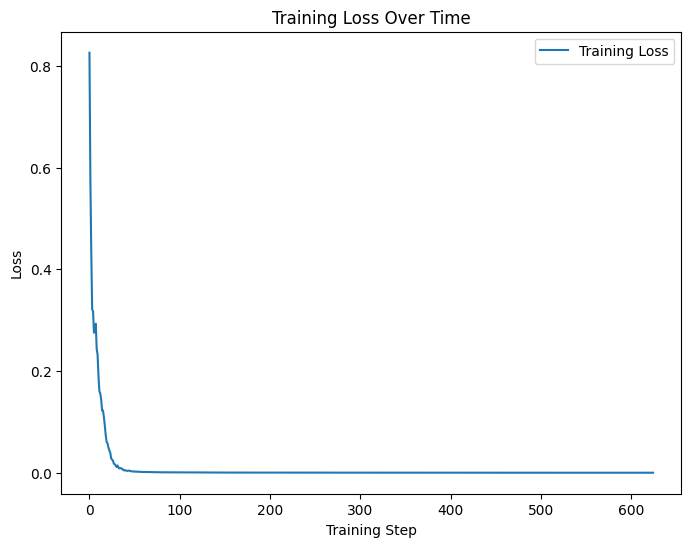

In [ ]:
# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

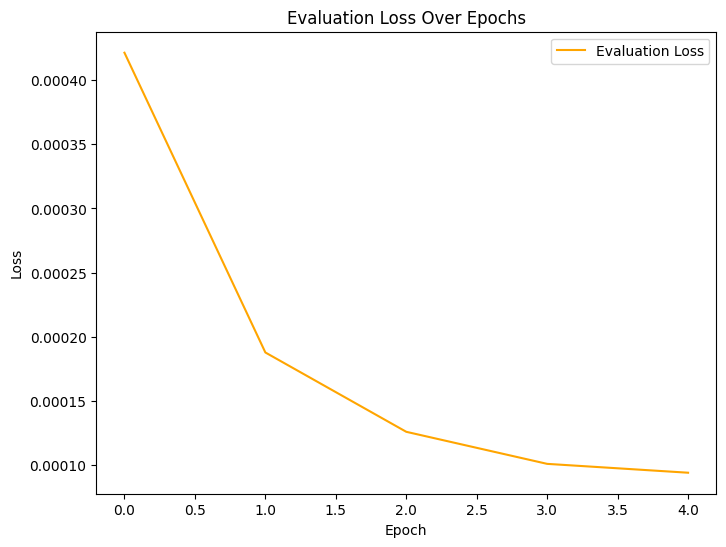

In [ ]:
# Plot Evaluation Loss
plt.figure(figsize=(8, 6))
plt.plot(eval_losses, label="Evaluation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss Over Epochs")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
# trainer.evaluate()

In [ ]:
# save model to results directory
model.save_pretrained("results/model_2")

In [ ]:
import torch

# Function to visualize model predictions
def visualize_predictions(model, tokenizer, question, sentence):
    # Move model to device
    model.eval()  # Set model to evaluation mode
    inputs = tokenizer(question, sentence, return_tensors="pt", truncation=True)
    
    # Move input tensors to the same device as the model
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the prediction (class with highest score)
    predicted_class = torch.argmax(outputs.logits, dim=-1).item()
    label_map = {0: "not_entailment", 1: "entailment"}
    predicted_label = label_map[predicted_class]

    print(f"Question: {question}")
    print(f"Sentence: {sentence}")
    print(f"Prediction: {predicted_label}")

# Example usage
visualize_predictions(model, tokenizer, 
                      "What is the capital of France?", 
                      "The capital of France is Paris.")


Question: What is the capital of France?
Sentence: The capital of France is Paris.
Prediction: entailment
